In [5]:
# standard libraries
import numpy as np
import pandas as pd
import bnlearn as bn
import matplotlib.pyplot as plt

# our methods
import sys
sys.path.append("..")

import helper.helper as h
import helper.methods as m

# notears
from notears.notears.notears import linear
from notears.notears.notears import utils

from importlib import reload  # Python 3.4+

In [2]:
reload(h);
reload(m);
reload(linear);
reload(utils);

### Load data

Loaded Sachs unmodified data, consisting of 11 variables, and 7466 measurements.


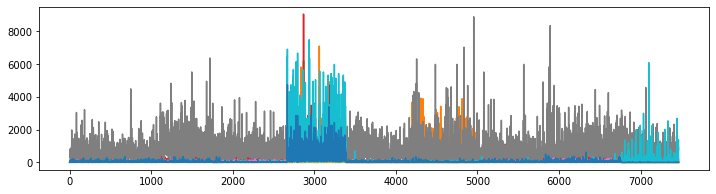

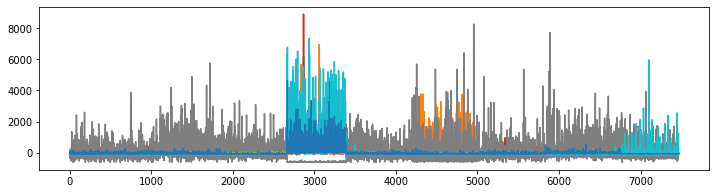

In [6]:
# load unmodified SACHS data
X = np.loadtxt("../../data/real_data/sem/gene_sachs/data.raw.txt", skiprows = 1);

# zero-mean version
X_a = X - np.mean(X, axis = 0)

# true adjacency matrix, note: discussiona bout the truth!
adj = np.round(bn.bnlearn.import_DAG('sachs', checkmodel = False, verbose = 0)['adjmat'].to_numpy());

print(f"Loaded Sachs unmodified data, consisting of {np.shape(X)[1]} variables, and {np.shape(X)[0]} measurements.")

plt.figure(figsize = (12, 3))
plt.plot(X);
plt.show()
plt.figure(figsize = (12, 3))
plt.plot(X_a);
plt.show()

### Perform NOTEARS

In [7]:
# perform notears with the usual lambda, no threshold (very small to remove the "near-precision" values)
W_NOTEARS, h_val = m._notears_2(X, lambda1 = 0.0, w_threshold = 1e-3, loss_type = "l2");

In [8]:
# manual thresholding
threshold = 0.3
W_NOTEARS_THRESHOLD = W_NOTEARS.copy()
W_NOTEARS_THRESHOLD[np.abs(W_NOTEARS_THRESHOLD) < threshold] = 0
print(f"W_NOTEARS, thresholded with value {threshold}, and {len(W_NOTEARS[np.abs(W_NOTEARS) > threshold])} edges:\n{np.round(W_NOTEARS_THRESHOLD, 1)}.")

W_NOTEARS, thresholded with value 0.3, and 20 edges:
[[ 0.   1.5  0.   0.   0.   0.   0.   0.7  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.6  0.   0.   0. ]
 [ 0.   0.   0.   1.6  0.   0.   0.  -0.4  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.5  0.8  0.   0.   0.   0.   0.   0.   0. ]
 [-1.4  0.  -0.8  0.   0.   0.   1.9  4.6  0.   0.  -0.4]
 [ 0.7  0.   0.6  0.   0.   0.   0.  -0.4  0.   0.   0.3]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   1.3  0.   5.1  1.4]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.3  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]].


In [9]:
# compare, use thresholding matrix
print(utils.count_accuracy(adj, W_NOTEARS_THRESHOLD != 0))
print(utils.count_accuracy(adj, W_NOTEARS != 0))

{'fdr': 0.65, 'tpr': 0.4117647058823529, 'fpr': 0.34210526315789475, 'shd': 20, 'nnz': 20}
{'fdr': 0.7777777777777778, 'tpr': 0.7058823529411765, 'fpr': 1.105263157894737, 'shd': 42, 'nnz': 54}


### OMP
#### Stupid approach (hopefully does not work, OMP for VAR)

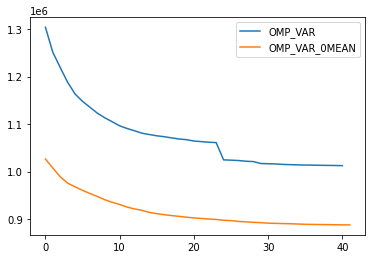

In [10]:
# OMP as if sachs data was VAR, which it obviously is not
W_OMP_var, Ws_var, mses_var, _ = m._OMP_2(X[:-1], X[1:], max_coefs = 60, output = True)

# mean squared error is much better, but that is because it is zero-meaned
plt.plot(mses_var, label = "OMP_VAR")

# OMP as if sachs data was VAR, which it obviously is not
W_OMP_var_a, Ws_var_a, mses_var_a, _ = m._OMP_2(X_a[:-1], X_a[1:], max_coefs = 60, output = True)

# mean squared error is much better, but that is because it is zero-meaned
plt.plot(mses_var_a, label = "OMP_VAR_0MEAN")
plt.legend()

#### SEM approach, hopefully works better

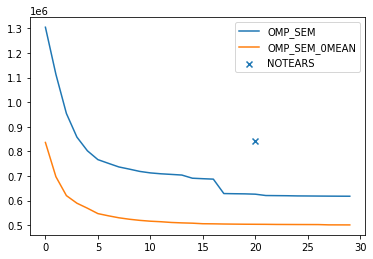

In [12]:
W_OMP_sem, Ws_sem, mses_sem, _ = m._OMP_SEM(X, max_coefs = 30, output = True)
plt.plot(mses_sem, label = "OMP_SEM")

W_OMP_sem_a, Ws_sem_a, mses_sem_a, _ = m._OMP_SEM(X_a, max_coefs = 30, output = True)
plt.plot(mses_sem_a, label = "OMP_SEM_0MEAN")

plt.scatter(len(W_NOTEARS_THRESHOLD[np.abs(W_NOTEARS_THRESHOLD) > 0]), h.MSE(W_NOTEARS_THRESHOLD, X, is_sem = True), marker = 'x', label = "NOTEARS")

plt.legend()

### Compare Accuracies

In [13]:
notears_score = h.score(X, W_NOTEARS_THRESHOLD, adj, printing = False, is_sem = True)
notears_score_a = h.score(X_a, W_NOTEARS_THRESHOLD, adj, printing = False, is_sem = True)
print(notears_score)

(0.4117647058823529, 0.875, 0.65, 0.7909090909090909, 23, 843953.7317599682, 0.41735819743692776)


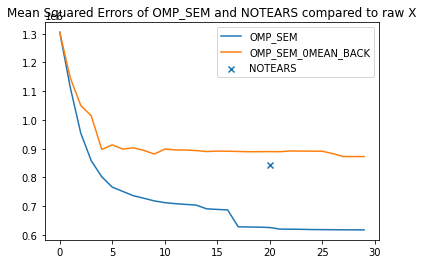

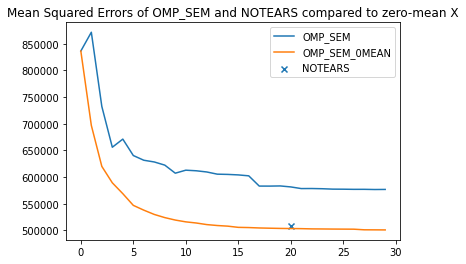

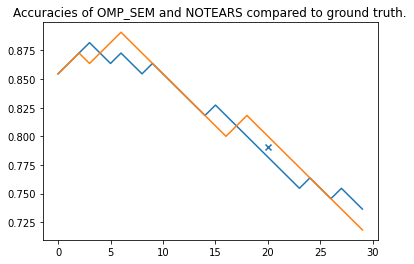

In [15]:
accs_OMP_SEM = []
accs_OMP_SEM_a = []
mses_OMP_SEM = []
mses_OMP_SEM_a = []
mses_OMP_SEM_on_Xa = []
mses_OMP_SEM_a_on_Xa = []

for W in Ws_sem:
    accs_OMP_SEM.append(h.score(X, W, adj, printing = False, is_sem = True)[3])
    mses_OMP_SEM.append(h.score(X, W, adj, printing = False, is_sem = True)[5])
    mses_OMP_SEM_on_Xa.append(h.score(X_a, W, adj, printing = False, is_sem = True)[5])
    
for W in Ws_sem_a:
    accs_OMP_SEM_a.append(h.score(X, W, adj, printing = False, is_sem = True)[3])
    mses_OMP_SEM_a.append(h.score(X, W, adj, printing = False, is_sem = True)[5])
    mses_OMP_SEM_a_on_Xa.append(h.score(X_a, W, adj, printing = False, is_sem = True)[5])

plt.title("Mean Squared Errors of OMP_SEM and NOTEARS compared to raw X")
plt.plot(mses_OMP_SEM, label = "OMP_SEM")
plt.plot(mses_OMP_SEM_a, label = "OMP_SEM_0MEAN_BACK")
plt.scatter(len(W_NOTEARS_THRESHOLD[np.abs(W_NOTEARS_THRESHOLD) > 0]), notears_score[5], marker = 'x', label = "NOTEARS")
plt.legend()
plt.show()

plt.title("Mean Squared Errors of OMP_SEM and NOTEARS compared to zero-mean X")
plt.plot(mses_OMP_SEM_on_Xa, label = "OMP_SEM")
plt.plot(mses_OMP_SEM_a_on_Xa, label = "OMP_SEM_0MEAN")
plt.scatter(len(W_NOTEARS_THRESHOLD[np.abs(W_NOTEARS_THRESHOLD) > 0]), notears_score_a[5], marker = 'x', label = "NOTEARS")
plt.legend()
plt.show()

plt.title("Accuracies of OMP_SEM and NOTEARS compared to ground truth.")
plt.plot(accs_OMP_SEM, label = "OMP_SEM")
plt.plot(accs_OMP_SEM_a, label = "OMP_SEM_0MEAN")
plt.scatter(len(W_NOTEARS_THRESHOLD[np.abs(W_NOTEARS_THRESHOLD) > 0]), notears_score[3], marker = 'x', label = "NOTEARS")

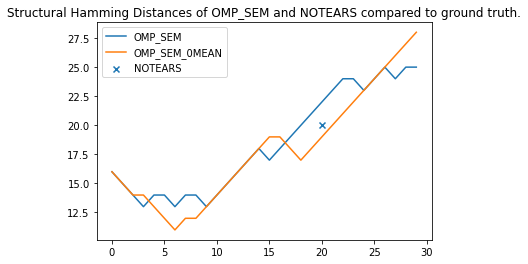

In [18]:
shd = [[], []]
for W in Ws_sem:
    shd[0].append(utils.count_accuracy(adj, W != 0)['shd'])
    
for W in Ws_sem_a:
    shd[1].append(utils.count_accuracy(adj, W != 0)['shd'])

plt.title("Structural Hamming Distances of OMP_SEM and NOTEARS compared to ground truth.")
plt.plot(shd[0], label = 'OMP_SEM')
plt.plot(shd[1], label = 'OMP_SEM_0MEAN')
plt.scatter(len(W_NOTEARS_THRESHOLD[np.abs(W_NOTEARS_THRESHOLD) > 0]), utils.count_accuracy(adj, W_NOTEARS_THRESHOLD != 0)['shd'], marker = 'x', label = "NOTEARS")
plt.legend()

In [19]:
print(f"Difference between 'optimal' OMP and NOTEARS:\n{np.round(np.abs(W_NOTEARS_THRESHOLD - Ws_sem_a[19]), 1)}.")

Difference between 'optimal' OMP and NOTEARS:
[[0.  0.  0.  0.  0.  0.  0.  0.7 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.4 0.  0.  0. ]
 [0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.  0.1 0.  0.  0.  0.  0.2 0.  0.  0.4]
 [0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.2 0.3]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.3 0.  0.1 0.4]
 [0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0. ]
 [0.  0.  0.2 0.  0.  0.  0.2 0.  0.  0.  0. ]].


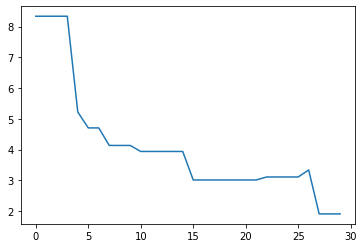

In [20]:
plt.plot([np.linalg.norm(W - W_NOTEARS_THRESHOLD, 1) for W in Ws_sem_a])

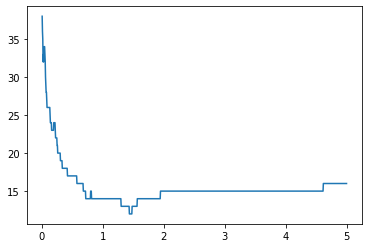

In [21]:
shds = []
for i in range(1, 1000, 1):
    threshold = i / 200
    
    W_t = W_NOTEARS.copy()
    W_t[np.abs(W_t) < threshold] = 0
    
    shds.append(utils.count_accuracy(adj, W_t != 0)['shd'])

plt.plot(np.array(range(1, 1000, 1)) / 200, shds)